In [60]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/PAC/cnn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/PAC/cnn


In [ ]:
%cd ..

C:\Users\Cliente\Documents\PAC\cnn


In [99]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import PillowWriter
from celluloid import Camera
from scipy import stats, signal
from skimage.transform import rotate
from src import data
from src import visualize as vs
from sklearn import cluster
from sklearn.mixture import GaussianMixture

In [3]:
def FFT(x):
    return np.abs(np.fft.fft(x))

def Cxx(x):
    return np.correlate(x, x, mode='same')

def PSD(x):
    return FFT(Cxx(x))

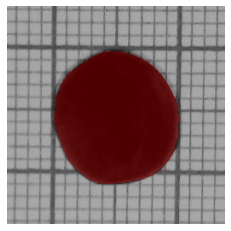

Escala verdadeira: 0.0047 mm/píxel


In [7]:
#img, G, areas = data.load_random(get_area=True, grayscale=True)
img, G = data.load_by_area(84.841, grayscale=True)
G /= tf.reduce_max(G)
scale_true = 84.841/np.sum(G) # mm^2/p^2

I = img[0, :, :, 0].numpy()
vs.plot_label(I, G)
plt.show()
print(f'Escala verdadeira: {scale_true:.4f} mm/píxel')

In [8]:
freqs = np.fft.fftfreq(img.shape[1])
loc = freqs > 0
freqs.shape

(256,)

# Detecção da escala

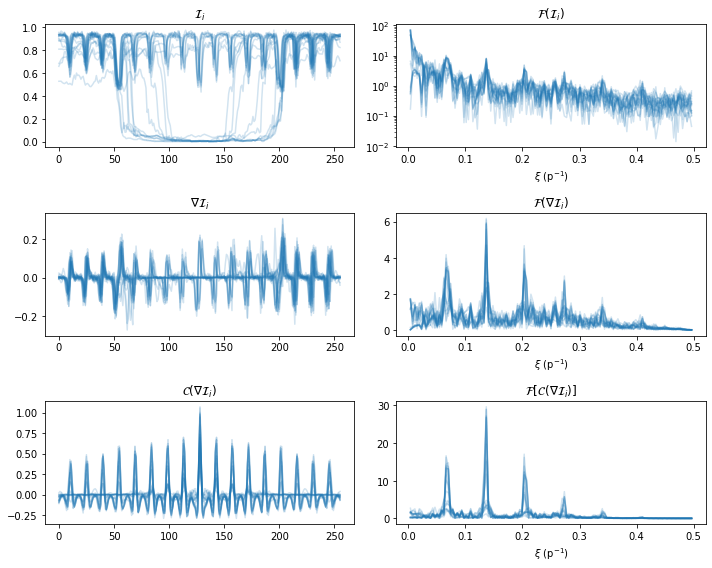

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))

axs[0, 0].set_title(r'$\mathcal{I}_i$')
axs[0, 1].set_title(r'$\mathcal{F}(\mathcal{I}_i)$')
axs[1, 0].set_title(r'$\nabla \mathcal{I}_i$')
axs[1, 1].set_title(r'$\mathcal{F}(\nabla \mathcal{I}_i)$')
axs[2, 0].set_title(r'$\mathcal{C}(\nabla \mathcal{I}_i)$')
axs[2, 1].set_title(r'$\mathcal{F}[\mathcal{C}(\nabla \mathcal{I}_i)]$')

Iy = np.gradient(I)[1]
for i in np.random.randint(0, I.shape[0], 20):
    axs[0, 0].plot(I[i], 'C0-', alpha=0.2)
    axs[0, 1].semilogy(freqs[loc], FFT(I[i])[loc], 'C0-', alpha=0.2)
    axs[1, 0].plot(Iy[i], 'C0-', alpha=0.2)
    axs[1, 1].plot(freqs[loc], FFT(Iy[i])[loc], 'C0-', alpha=0.2)
    axs[2, 0].plot(Cxx(Iy[i]), 'C0-', alpha=0.2)
    axs[2, 1].plot(freqs[loc], FFT(Cxx(Iy[i]))[loc], 'C0-', alpha=0.2)

for ax in axs[:, 1]: ax.set_xlabel(r'$\xi$ (p$^{-1}$)')
fig.tight_layout()
plt.show()

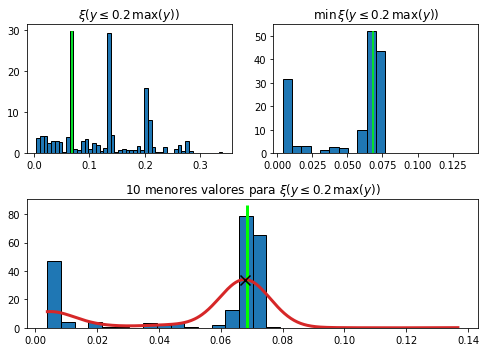

Moda: 0.06778400551102204
Erro: 1.09%


In [98]:
T1 = 0.2
freq_true = np.sqrt(scale_true)

I = img[0, :, :, 0].numpy()
I = np.concatenate((I, I.T))
Iy = np.gradient(I)[1]
F = map(PSD, Iy)
th = list(map(lambda y: np.abs(freqs[signal.find_peaks(y, prominence=y.max()*T1)[0]]), F))
min_th = [np.min(f) for f in th if len(f)]

fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title(r'$\xi(y \leq {}\,\max(y))$'.format(T1))
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title(r'$\min\,\xi(y \leq {}\,\max(y))$'.format(T1))
ax3 = fig.add_subplot(gs[1, :])
ax3.set_title(r'{} menores valores para $\xi(y \leq {}\,\max(y))$'.format(T2, T1))
fig.tight_layout()

h, _, _ = ax1.hist(np.concatenate(th), bins=50, edgecolor='k', density=True)
ax1.vlines(freq_true, h.min(), h.max(), color='lime')
h, bins, _ = ax2.hist(min_th, bins=20, edgecolor='k', density=True)
ax2.vlines(freq_true, h.min(), h.max(), color='lime')

D = np.stack(min_th)
kernel = stats.gaussian_kde(D)

h, bins, _ = ax3.hist(D, bins=30, density=True, edgecolor='k')
x = np.linspace(bins.min(), bins.max(), 500)
f = kernel(x)
pred_freq = x[f == f.max()][0]

ax3.plot(x, f, 'C3-', lw=3)
ax3.vlines(freq_true, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)
ax3.scatter(pred_freq, f.max(), marker='x', c='k', zorder=4, s=100)

plt.show()
print(
    'Moda: %s'%pred_freq,
    f'Erro: {(np.abs(freq_true - pred_freq)/freq_true*100):.2f}%',
    sep='\n'
)

In [13]:
def Pxx(x, freqs, T1, T2):
    y = PSD(x)
    return np.sort(np.abs(freqs[y > T1*y.max()]))[:T2]

def find_scale(img, T1, T2):
    scale = 1
    Ix, Iy = np.gradient(img)
    for I in (Ix.T, Iy):
        freqs = np.fft.fftfreq(len(I), 1)
        D = np.concatenate(list(map(lambda x: Pxx(x, freqs, T1, T2), I)))
        x = np.linspace(D.min(), D.max(), 500)
        f = stats.gaussian_kde(D)(x)
        scale *= x[f == f.max()][0]
        #scale *= mode(D).mode[0]
    return scale

In [15]:
jpg_files = list(data.Paths.DATA.glob('**/*.jpg'))
images = data.load_collection(jpg_files, grayscale=True)
labels = data.load_collection(map(lambda file: file.with_suffix('.png'), jpg_files), grayscale=True)/255
images.shape, labels.shape

(TensorShape([63, 256, 256, 1]), TensorShape([63, 256, 256, 1]))

In [16]:
areas_true = np.stack(list(map(lambda file: float(file.stem), jpg_files)))
scales_true = areas_true/tf.reduce_sum(labels, axis=(1, 2, 3)).numpy()

In [19]:
%%time
scales_pred = np.array([find_scale(images[i, :, :, 0].numpy(), 0.1, 10) for i in range(len(images))])

CPU times: user 5.64 s, sys: 20.4 ms, total: 5.66 s
Wall time: 6.8 s


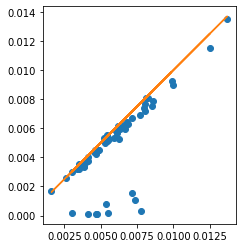

In [20]:
fig, ax = plt.subplots()
plt.plot(scales_true, scales_pred, 'o')
plt.plot(scales_true, scales_true, '-')
ax.set_aspect('equal')

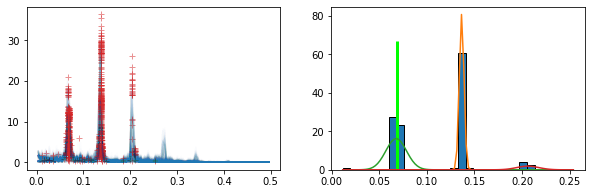

Moda: 0.0678519514456106
Erro: 1.00%


In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

D = []
for y in map(PSD, Iy):
    ax1.plot(freqs[loc], y[loc], 'C0-', alpha=0.01)
    peaks, _ = signal.find_peaks(y[loc], prominence=y[loc].max()*0.6)
    x = freqs[loc][peaks]
    x = np.abs(freqs[loc][peaks])
    D.append(x)
    ax1.plot(x, y[loc][peaks], 'C3+', alpha=0.5)

D = np.concatenate(D)

h, bins, _ = ax2.hist(D, bins=30, density=True, edgecolor='k')

gsm = GaussianMixture(3).fit(D.reshape(-1, 1))
x = np.linspace(D.min(), D.max(), 100)
freq_pred = np.inf
for mean, cov, weight in zip(gsm.means_, gsm.covariances_, gsm.weights_):
    ax2.plot(x, stats.norm.pdf(x, mean, np.sqrt(np.diag(cov)))*weight)
    freq_pred = min(freq_pred, float(mean))

ax2.vlines(freq_true, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)

plt.show()
print(
    'Moda: %s'%freq_pred,
    f'Erro: {(np.abs(freq_true - freq_pred)/freq_true*100):.2f}%',
    sep='\n'
)

# Detecção da inclinação

In [ ]:
angle = 40

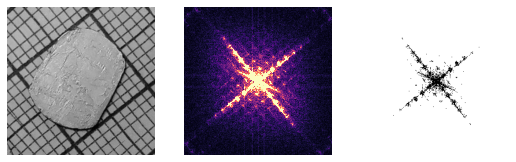

In [ ]:
T3 = 25e-4

fig = plt.figure(figsize=(9, 3))

I = rotate(img[0, :, :, 0].numpy(), angle, mode='reflect')
fft2d = np.abs(np.fft.fftshift(np.fft.fft2(I)))
L = fft2d > fft2d.max()*T3

fig.add_subplot(131)
vs.plot_image(I, cmap='gray')

fig.add_subplot(132)
vs.plot_image(fft2d, cmap='magma', vmax=fft2d.max()*T3)

fig.add_subplot(133)
vs.plot_image(L, cmap='binary')

plt.show()

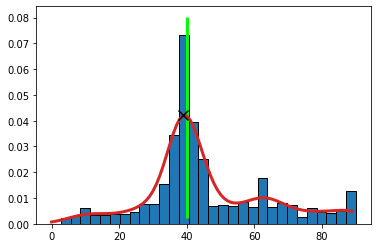

Moda: 39
Erro: 2.50%


In [ ]:
X, Y = np.meshgrid(*[np.fft.fftshift(freqs)]*2)
H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90

kernel = stats.gaussian_kde(H)

h, bins, _ = plt.hist(H, bins=30, density=True, edgecolor='k')
x = np.arange(0, 90)
f = kernel(x)
pred_angle = x[f == f.max()][0]

plt.plot(x, f, 'C3-', lw=3)
plt.vlines(angle, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)
plt.scatter(pred_angle, f.max(), marker='x', c='k', zorder=4, s=100)
plt.show()
print(
    'Moda: %s'%pred_angle,
    f'Erro: {(np.abs(angle - pred_angle)/angle*100):.2f}%',
    sep='\n'
)

In [ ]:
def find_slope(img, t=25e-4):
    fft2d = np.abs(np.fft.fftshift(np.fft.fft2(img)))
    L = fft2d > fft2d.max()*t
    X, Y = np.meshgrid(*[np.fft.fftshift(freqs)]*2)
    H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90
    kernel = stats.gaussian_kde(H)
    x = np.arange(0, 90)
    f = kernel(x)
    return x[f == f.max()]

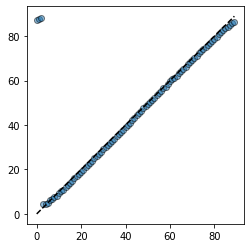

In [ ]:
At = np.arange(90)
A = [find_slope(rotate(img[0, :, :, 0].numpy(), a, mode='reflect')) for a in At]

fig, ax = plt.subplots()
ax.scatter(At, A, alpha=0.5, edgecolor='k')
ax.plot(At, At, 'k--')
ax.set_aspect('equal')
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2:])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xlabel('inclinação')
fig.tight_layout()

camera = Camera(fig)
for angle in range(90):
    I = rotate(img[0, :, :, 0].numpy(), angle, mode='reflect')
    fft2d = np.abs(np.fft.fftshift(np.fft.fft2(I)))
    L = fft2d > fft2d.max()*25e-4
    X, Y = np.meshgrid(*[np.fft.fftshift(freqs)]*2)
    H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90
    
    ax1.imshow(I, cmap='gray')
    ax2.imshow(fft2d, cmap='magma', vmax=fft2d.max()*25e-4)

    h, bins, _ = plt.hist(H, bins=30, density=True, edgecolor='k', alpha=0.7, color='C0')
    x = np.linspace(bins.min(), bins.max(), 100)
    kernel = stats.gaussian_kde(H)
    f = kernel(x)
    pred_angle = x[f == f.max()][0]

    plt.plot(x, f, 'C3-', lw=3)
    plt.vlines(angle, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)
    plt.scatter(pred_angle, f.max(), marker='x', c='k', zorder=4, s=100)

    camera.snap()

animation = camera.animate()
animation.save('reports/figures/slope_detection.gif', writer=PillowWriter(fps=10))
plt.close()

![](../reports/figures/slope_detection.gif)